In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql.types import IntegerType
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.evaluation import ClusteringEvaluator
spark = SparkSession.builder.appName("PySpark").getOrCreate()
# spark

In [2]:
def printdf(df, l=5):
    return df.limit(l).toPandas()

def nullcount(df):
    return {col: df.filter(df[col].isNull()).count() for col in df.columns}

def shape(df):
    print((df.count(), len(df.columns)))

In [3]:
data = spark.read.csv("customer_big_data.csv", 
                             inferSchema=True, 
                             header=True)
printdf(data)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"""RECORD FRAME 7"""" SINGLE SIZE """,48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [4]:
data.printSchema()

root
 |-- Invoice: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- Price: double (nullable = true)
 |-- Customer ID: double (nullable = true)
 |-- Country: string (nullable = true)



In [5]:
nullcount(data)

{'Invoice': 0,
 'StockCode': 0,
 'Description': 4382,
 'Quantity': 0,
 'InvoiceDate': 0,
 'Price': 0,
 'Customer ID': 243007,
 'Country': 0}

In [6]:
# Filter out null customer ids
data_new = data.filter(F.col("Customer ID").isNotNull())

In [7]:
nullcount(data_new)

{'Invoice': 0,
 'StockCode': 0,
 'Description': 0,
 'Quantity': 0,
 'InvoiceDate': 0,
 'Price': 0,
 'Customer ID': 0,
 'Country': 0}

In [8]:
data_new.toPandas().describe()

,Quantity,Price,Customer ID
count,824364.000000,824364.000000,824364.000000
mean,12.414574,3.676800,15324.638504
std,188.976099,70.241388,1697.464450
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13975.000000
50%,5.000000,1.950000,15255.000000
75%,12.000000,3.750000,16797.000000
max,80995.000000,38970.000000,18287.000000


In [9]:
# Remove negative Quantities


# Introduce Total Amount column
data_new = data_new.withColumn("Total", F.round(F.col("Quantity") * F.col("Price")))

# Reformat invoice date to yyyy-MM-dd
data_new = data_new.withColumn("InvoiceDate", 
                               F.to_date(F.col("InvoiceDate"),'MM/dd/yyyy'))

In [10]:
data_new.toPandas().describe()

,Quantity,Price,Customer ID,Total
count,824364.000000,824364.000000,824364.000000,824364.000000
mean,12.414574,3.676800,15324.638504,20.270026
std,188.976099,70.241388,1697.464450,308.685483
min,-80995.000000,0.000000,12346.000000,-168470.000000
25%,2.000000,1.250000,13975.000000,4.000000
50%,5.000000,1.950000,15255.000000,11.000000
75%,12.000000,3.750000,16797.000000,20.000000
max,80995.000000,38970.000000,18287.000000,168470.000000


In [11]:
printdf(data_new)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Total
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01,6.95,13085.0,United Kingdom,83.0
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"""RECORD FRAME 7"""" SINGLE SIZE """,48,2009-12-01,2.10,13085.0,United Kingdom,101.0
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01,1.25,13085.0,United Kingdom,30.0


In [12]:
data_new.printSchema()

root
 |-- Invoice: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: date (nullable = true)
 |-- Price: double (nullable = true)
 |-- Customer ID: double (nullable = true)
 |-- Country: string (nullable = true)
 |-- Total: double (nullable = true)



In [13]:
data_new.select(F.max('InvoiceDate')).collect()

[Row(max(InvoiceDate)=datetime.date(2011, 12, 9))]

In [14]:
latest_date = F.to_date(F.lit("2011/12/10"), 'yyyy/MM/dd')

In [15]:
last_transaction = (
    data_new.groupBy("Customer ID")
            .agg((F.datediff(latest_date, F.max(F.col("InvoiceDate")))).alias("Last_Transaction"))
)

no_of_transaction = (
    data_new.groupBy("Customer ID", "Invoice").count()
            .groupBy("Customer ID")
            .agg(F.count("*").alias("No_Of_Transaction"))
)

total_paid = (
    data_new.groupBy("Customer ID")
            .agg(F.sum(F.col("Total")).alias("Total_Paid"))
)

rfm_score = (
    last_transaction.join(no_of_transaction, 'Customer ID', how = 'inner')
           .join(total_paid,'Customer ID', how = 'inner')
)

In [16]:
printdf(rfm_score)

,Customer ID,Last_Transaction,No_Of_Transaction,Total_Paid
0,14285.0,22,9,3158.0
1,17884.0,4,23,3062.0
2,16822.0,664,3,144.0
3,16596.0,16,4,585.0
4,17072.0,626,1,285.0


In [17]:
rfm_score.toPandas().describe()

,Customer ID,Last_Transaction,No_Of_Transaction,Total_Paid
count,5942.000000,5942.000000,5942.000000,5942.000000
mean,15316.500000,203.457085,7.552339,2812.164254
std,1715.451981,211.881245,15.972262,13982.436433
min,12346.000000,1.000000,1.000000,-25111.000000
25%,13831.250000,25.000000,2.000000,328.000000
50%,15316.500000,96.500000,4.000000,850.000000
75%,16801.750000,382.000000,8.000000,2191.000000
max,18287.000000,739.000000,510.000000,598231.000000


In [18]:
rfm_score = rfm_score.filter(F.col("Total_Paid") > 0)

In [19]:
rfm_score.toPandas().describe()

,Customer ID,Last_Transaction,No_Of_Transaction,Total_Paid
count,5837.000000,5837.000000,5837.000000,5837.000000
mean,15319.615042,197.901833,7.649820,2878.881446
std,1714.977802,207.864821,16.095458,14093.601133
min,12347.000000,1.000000,1.000000,2.000000
25%,13838.000000,25.000000,2.000000,342.000000
50%,15321.000000,93.000000,4.000000,884.000000
75%,16801.000000,376.000000,8.000000,2246.000000
max,18287.000000,739.000000,510.000000,598231.000000


In [20]:
printdf(rfm_score)

,Customer ID,Last_Transaction,No_Of_Transaction,Total_Paid
0,14285.0,22,9,3158.0
1,17884.0,4,23,3062.0
2,16822.0,664,3,144.0
3,16596.0,16,4,585.0
4,17072.0,626,1,285.0


In [21]:
df_rfm_score = rfm_score.toPandas()

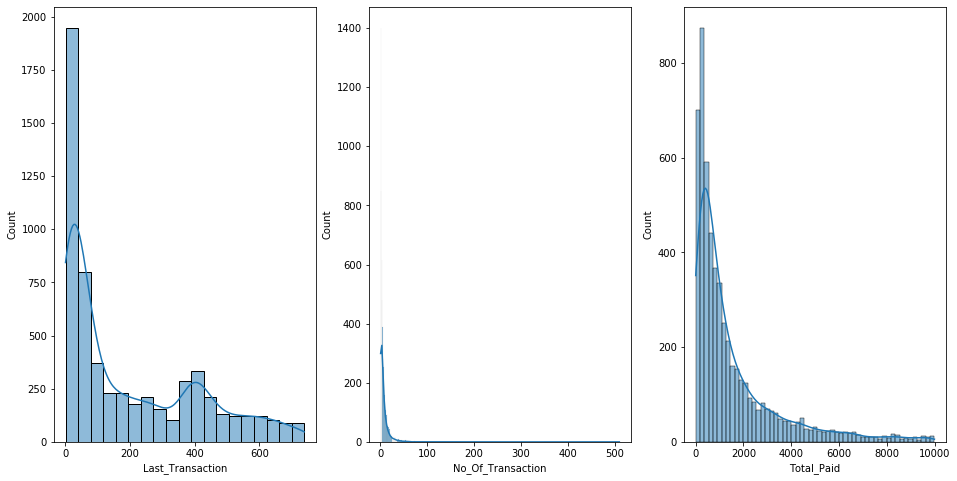

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(16, 8))

# Recency distribution plot
sns.histplot(df_rfm_score['Last_Transaction'], kde=True, ax=ax[0])

# Frequency distribution plot
sns.histplot(df_rfm_score.query('No_Of_Transaction < 1000')['No_Of_Transaction'], kde=True, ax=ax[1])

# Monetary distribution plot
sns.histplot(df_rfm_score.query('Total_Paid < 10000')['Total_Paid'], kde=True, ax=ax[2])

In [23]:
features = rfm_score.columns[1:]

printdf(rfm_score)

,Customer ID,Last_Transaction,No_Of_Transaction,Total_Paid
0,14285.0,22,9,3158.0
1,17884.0,4,23,3062.0
2,16822.0,664,3,144.0
3,16596.0,16,4,585.0
4,17072.0,626,1,285.0


In [25]:
assembler = VectorAssembler(
    inputCols=features, 
    outputCol="rfm_features")

assembled_data = assembler.transform(rfm_score)

assembled_data = assembled_data.select('Customer ID', 'rfm_features')

printdf(assembled_data)

,Customer ID,rfm_features
0,14285.0,"[22.0, 9.0, 3158.0]"
1,17884.0,"[4.0, 23.0, 3062.0]"
2,16822.0,"[664.0, 3.0, 144.0]"
3,16596.0,"[16.0, 4.0, 585.0]"
4,17072.0,"[626.0, 1.0, 285.0]"


In [35]:
scaler = StandardScaler(inputCol='rfm_features', outputCol='rfm_standardized')

data_scale = scaler.fit(assembled_data)

scaled_data = data_scale.transform(assembled_data)
scaled_data = scaled_data.withColumn("Customer ID", scaled_data["Customer ID"].cast(IntegerType()))
printdf(scaled_data)

,Customer ID,rfm_features,rfm_standardized
0,14285,"[22.0, 9.0, 3158.0]","[0.10583801470115888, 0.5591639429672356, 0.22..."
1,17884,"[4.0, 23.0, 3062.0]","[0.019243275400210706, 1.4289745209162688, 0.2..."
2,16822,"[664.0, 3.0, 144.0]","[3.1943837164349773, 0.18638798098907855, 0.01..."
3,16596,"[16.0, 4.0, 585.0]","[0.07697310160084282, 0.24851730798543806, 0.0..."
4,17072,"[626.0, 1.0, 285.0]","[3.0115726001329755, 0.062129326996359514, 0.0..."


In [38]:
costs = {}

for k in range(2, 10):
    k_means = KMeans(featuresCol='rfm_standardized', k=k)
    model = k_means.fit(scaled_data)
    costs[k] = model.summary.trainingCost

[2, 3, 4, 5, 6, 7, 8, 9]

Text(0, 0.5, 'cost')

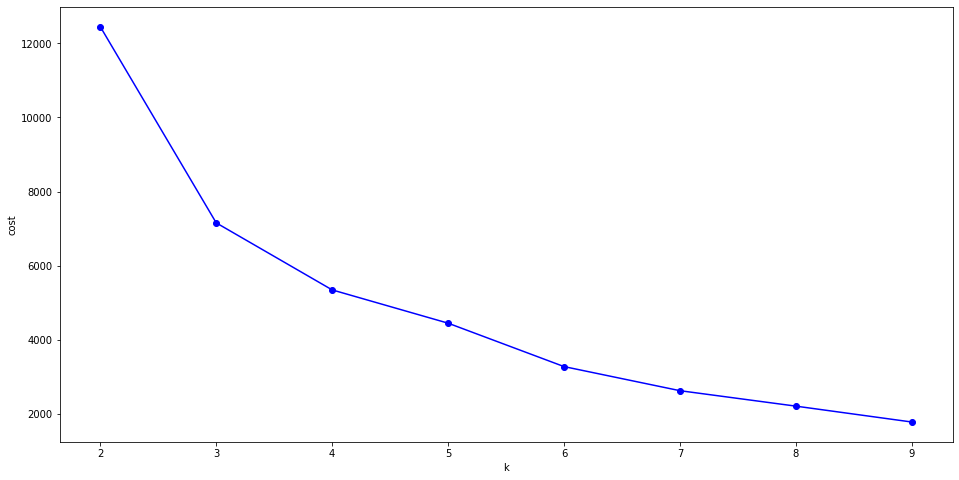

In [61]:
fig, ax = plt.subplots(1, 1, figsize =(16, 8))
ax.plot(list(costs.keys()), list(costs.values()), '-ob')
ax.set_xlabel('k')
ax.set_ylabel('cost')

# K = 6

In [86]:
k_means = KMeans(featuresCol='rfm_standardized', k=6)
model = k_means.fit(scaled_data)
predictions = model.transform(scaled_data)

In [87]:
result = predictions.select('Customer ID', 'prediction')
printdf(result)

,Customer ID,prediction
0,14285,0
1,17884,0
2,16822,3
3,16596,0
4,17072,3


In [88]:
combined_result = result.join(rfm_score, on='Customer ID', how='inner')
printdf(combined_result)

,Customer ID,prediction,Last_Transaction,No_Of_Transaction,Total_Paid
0,14285,0,22,9,3158.0
1,17884,0,4,23,3062.0
2,16822,3,664,3,144.0
3,16596,0,16,4,585.0
4,17072,3,626,1,285.0


In [89]:
combined_result_df = combined_result.toPandas()

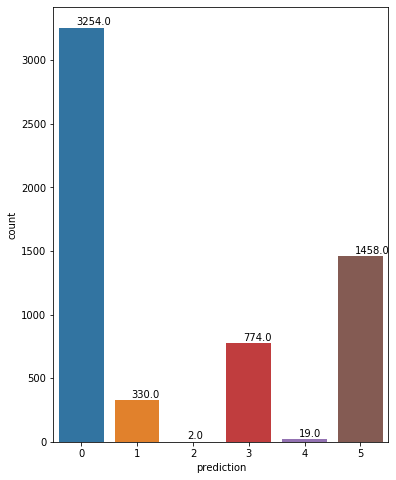

In [90]:
fig, ax = plt.subplots(1, 1, figsize=(6, 8))

sns.countplot(x="prediction", data=combined_result_df)
for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()), (p.get_x() + 0.3, p.get_height() + 20))

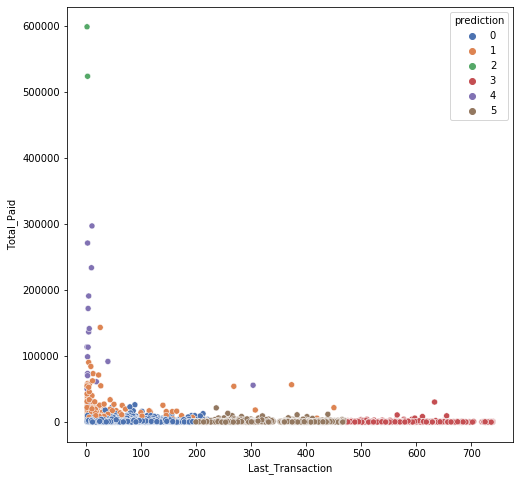

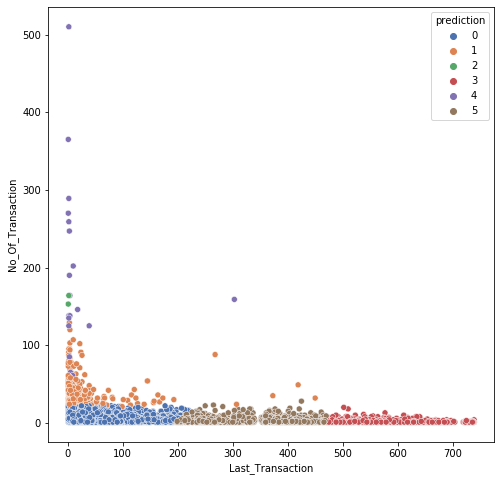

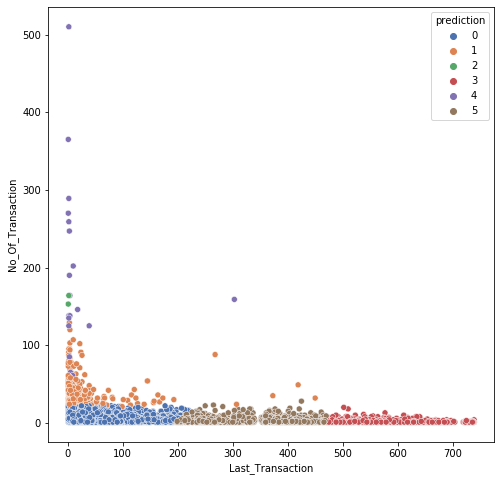

In [91]:
selected_result_df = combined_result_df#.query('Monetary < 100000').query('Frequency < 3000')

# Monetary vs Frequency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Last_Transaction', y='Total_Paid', data=selected_result_df, hue='prediction', palette="deep")

# Monetary vs Frequency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Last_Transaction', y='No_Of_Transaction', data=selected_result_df, hue='prediction', palette="deep")

# Monetary vs Frequency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Last_Transaction', y='No_Of_Transaction', data=selected_result_df, hue='prediction', palette="deep")

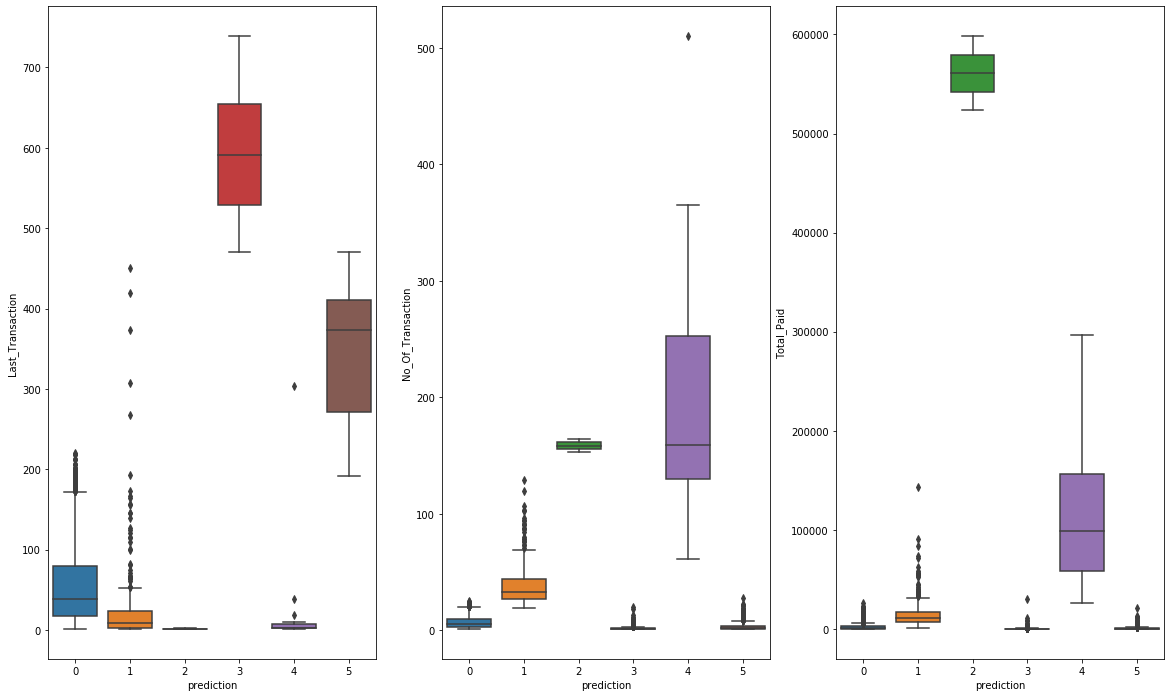

In [92]:
fig, ax = plt.subplots(1, 3, figsize=(20, 12))
sns.boxplot(x='prediction', y='Last_Transaction', data=selected_result_df, ax=ax[0])
sns.boxplot(x='prediction', y='No_Of_Transaction', data=selected_result_df, ax=ax[1])
sns.boxplot(x='prediction', y='Total_Paid', data=selected_result_df, ax=ax[2])

In [98]:
printdf(combined_result.filter(F.col("prediction") == 2))

,Customer ID,prediction,Last_Transaction,No_Of_Transaction,Total_Paid
0,18102,2,1,153,598231.0
1,14646,2,2,164,523346.0
